<a href="https://colab.research.google.com/github/catastrophically-cool/catastrophically-cool/blob/main/Transfer_Learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ImageNet**
* 1000 classes 
* 1.5 million images 
* benchmark dataset

# **Transfer Learning**
##(Introduction)




1.   Using trained model weights and biases as a starting point.
2.   Reduces computational cost
3.   Base model n/w remains same, classifier network varies according to the task.



#**STEP #1:**Import Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

In [ ]:
tf. __version__

'2.6.0'

# **STEP #2**: Import Model with **pretrained** weights 

In [ ]:
model = tf.keras.applications.ResNet50(weights="imagenet")

# **STEP #3**: Evaluate  pretrained model

## Mount drive to load images for evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###The images used for predictions are:[white_owl,snow_owl,bus]

In [ ]:
Sample_Image = tf.keras.preprocessing.image.load_img(r"/content/drive/MyDrive/Colab Notebooks/snow_owl.jpg",target_size=(224,224))

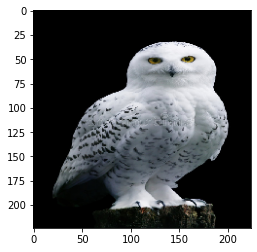

In [ ]:
plt.imshow(Sample_Image)

In [ ]:
# Converting PIL to image array
Sample_Image = tf.keras.preprocessing.image.img_to_array(Sample_Image)

Function: img_to_array()


In [ ]:
np.shape(Sample_Image)

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


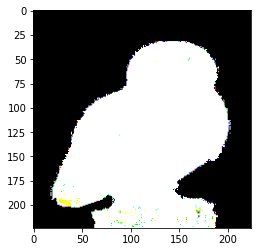

In [ ]:
plt.imshow(Sample_Image)

In [ ]:
Sample_Image = np.expand_dims(Sample_Image, axis=0)

In [ ]:
"The output is in the form(number_of_images(batch_size),image_size)"
np.shape(Sample_Image) 

(1, 224, 224, 3)

In [ ]:
Sample_Image.max()

255.0

In [ ]:
Sample_Image.min()

0.0

## **Preprocess according to the model input format requirements**

In [ ]:
Sample_Image = tf.keras.applications.resnet50.preprocess_input(Sample_Image)

In [ ]:
[Sample_Image.max(),Sample_Image.min()]

[151.061, -123.68]

We can see the variations in max and min values of the Sample_Image variable after the preprocessing.

## **Get Predictions on the custom test image on the pretrained model**

In [ ]:
predictions = model.predict(Sample_Image)

In [ ]:
print("The predictions of the model on this image are:", tf.keras.applications.resnet50.decode_predictions(predictions,top=5)[0])

The predictions of the model on this image are: [('n01796340', 'ptarmigan', 0.7610029), ('n01608432', 'kite', 0.13149308), ('n01819313', 'sulphur-crested_cockatoo', 0.058305364), ('n01614925', 'bald_eagle', 0.01074337), ('n02058221', 'albatross', 0.009379717)]


##**Conclusion:**
The bus was predicted correctly with fair probabilites, but the owl images werent predicted correctly in top 5 predictions

# **STEP #4:** Apply TRANSFER LEARNING and retrain Model

##Load Base Model(RESNET50 here)

In [ ]:
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False)

# (include_top=False) because we want to design our own classifier. Include only top of the network 

In [ ]:
print(base_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

## **Designing classifier according to desired requirements**

In [ ]:
# Dense fully connected network for classification layer:

x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
preds = tf.keras.layers.Dense(2, activation="softmax")(x)

## **Create model object based on the modified network**

In [ ]:
model = tf.keras.models.Model(inputs= base_model.input, outputs=preds)

In [ ]:
#print(model.summary())

## **Freezing base model**

In [ ]:
# Freezing the feature extraction Layers

for layer in model.layers[:175]:
  layer.trainable = False

## **Training the new classifier**(which is newly added to the top of the base model)

In [ ]:
#Training the classifier network parameters

for layer in model.layers[175:]:
  layer.trainable = True

##**Getting the training data and preprocessing it according to model requirements**

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet50.preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Transfer Learning Data/train', 
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   shuffle = True)

Found 202 images belonging to 2 classes.


##**Compile the new model on the training dataset**
* optimizer= ADAM
* loss= categorical_crossentropy
* metrics= accuracy




In [ ]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=['accuracy'])

##**Fitting the model**

In [ ]:
history = model.fit_generator(generator=train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs = 10)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
6/6 [==============================] - 7s 334ms/step - loss: 0.9399 - accuracy: 0.6941
Epoch 2/10
6/6 [==============================] - 1s 225ms/step - loss: 0.1815 - accuracy: 0.9323
Epoch 3/10
6/6 [==============================] - 1s 219ms/step - loss: 0.0583 - accuracy: 0.9824
Epoch 4/10
6/6 [==============================] - 1s 225ms/step - loss: 0.0235 - accuracy: 0.9948
Epoch 5/10
6/6 [==============================] - 1s 217ms/step - loss: 0.0053 - accuracy: 0.9941
Epoch 6/10
6/6 [==============================] - 2s 226ms/step - loss: 6.1510e-04 - accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 1s 242ms/step - loss: 7.4036e-04 - accuracy: 1.0000
Epoch 8/10
6/6 [==============================] - 1s 219ms/step - loss: 1.3842e-04 - accuracy: 1.0000
Epoch 9/10
6/6 [==============================] - 1s 218ms/step - loss: 2.3816e-05 - accuracy: 1.0000
Epoch 10/10
6/6 [==============================] - 1s 219ms/step - loss: 1.7088e-05 - accuracy: 1.0000

#**STEP #5:**Evaluate the Model

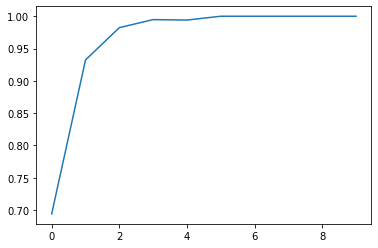

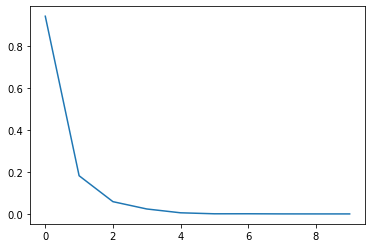

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
plt.figure()
plt.plot(acc)
plt.figure()
plt.plot(loss)
#plt.legend(["Accuracy","Loss"])

#**STEP #6:**Test the Model

##**Load & Preprocess input image**

In [ ]:
Sample_Image= tf.keras.preprocessing.image.load_img(r'/content/drive/MyDrive/Colab Notebooks/Transfer Learning Data/watch.jpg', target_size = (224, 224))

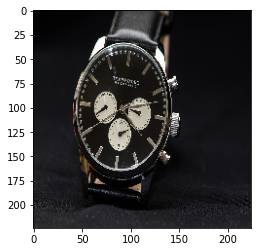

In [ ]:
plt.imshow(Sample_Image)

In [ ]:
Sample_Image = tf.keras.preprocessing.image.img_to_array(Sample_Image)
np.shape(Sample_Image)

(224, 224, 3)

In [ ]:
Sample_Image = np.expand_dims(Sample_Image, axis = 0)

##**Get Predictions on test image**

In [ ]:
Sample_Image = tf.keras.applications.resnet50.preprocess_input(Sample_Image)
predictions = model.predict(Sample_Image)
print('Predictions:', predictions)

Predictions: [[0.03186487 0.9681351 ]]
